<a href="https://colab.research.google.com/github/4di03/NBAPrediction/blob/main/NBAPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> Overview </h1>

I will be using PGMs and Bayesian Inference to predict the probability of an NBA team winning a championship , given various team statistics.

We will use a multi-node PGM, also called a Naive Bayes Classifier, to calculate this.

In [273]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
random.seed(0)
sns.set_style('darkgrid')

SIMPLE = False
BEST = True


<h1>Load + Prep in Data </h1>

Dataset is from http://www.hoopsstats.com/basketball/fantasy/nba/teamstats


In [274]:
DATA_URL = 'https://drive.google.com/file/d/1l8t9lRmk6l8xoX9X1dVmZNEIOw9sgM7E/view?usp=sharing'

RECORDS_URL = 'https://drive.google.com/file/d/1lWMo9p6gYO07MljdLUa_81f45HP4WQg-/view?usp=sharing'
def read_google_drive_csv(url):
    '''
    url: a public google drive csv file
    '''
    url='https://drive.google.com/uc?id=' + url.split('/')[-2]
    df = pd.read_csv(url)

    return df


df = read_google_drive_csv(DATA_URL)

# df = df[df["Team"] != "L.A.Lakers"]
# df = df[df["Team"] != "L.A.Clippers"]
#print(df.columns)
df.rename(columns = {"No":"Champion"}, inplace=True)

df["No"] = df["Champion"]

df.drop(["Fgm-a", "3gm-a", "Ftm-a", "Pf", "Dreb","Oreb", "G", "Min"],axis = 1, inplace = True)


df.rename(mapper = {"Pct" : "Fg-Pct", "Pct.1":"3-Pct", "Pct.2":"Ft-Pct"}, axis = 1, inplace= True)

oh = lambda x : 1 if x == 1 else 0
df["Champion"] = df["Champion"].apply(oh)


#df["Year"] = df["Year"].apply(fix_ts)


record_df = read_google_drive_csv(RECORDS_URL)

record_df = record_df[["Season", "Team", "W/L%"]]
for i, entry in record_df.iterrows():
    year = entry["Season"]
    fy, ly = year.split("-")

    pre = fy[:2] if fy != "1999" else "20"

    year = fy + "-" + pre + ly

    entry["Season"] = year

    record_df.at[i, "Season"] = year





for i, entry in df.iterrows():
    if "Lakers" in entry["Team"]:
        x = record_df[record_df["Team"].str.contains("Lakers")]
    elif "Clippers" in entry["Team"]:
        x = record_df[record_df["Team"].str.contains("Clippers")]
    else:
        x = record_df[record_df["Team"].str.contains(entry["Team"])]

        #print(x)

    prior_x = x.copy()
  #  print("AFTER YEAR FILTERING:")
    x = x[x["Season"] == entry["Year"]]

    if len(x) == 0:
        #print(prior_x, entry["Year"])

       # print(entry)
        df.drop(i,axis=0,inplace=True)

    else:
        df.loc[i, "Win-pct"] = x["W/L%"].values[0]



if SIMPLE:
    df.drop(["Pts", "Reb", "Stl", "Blk", "To", "Fg-Pct","Ft-Pct","Ast", "3-Pct"],axis = 1, inplace = True)

elif BEST:
    df.drop(["Pts", "Reb", "Ast", "Blk", "To", "3-Pct", "Fg-Pct","Win-pct" ],axis = 1, inplace = True)




feat = set(df.columns)
feat.remove("Year")
feat.remove("Champion")
feat.remove("Team")
feat.remove("No")

print(df.head(), f"\nrows: {len(df.index)}", f"\nFeatures:{feat}")


   Champion         Team  Stl  Ft-Pct    Eff  Deff       Year  No
0         1      Chicago  8.6   0.741  111.6  17.5  1997-1998   1
1         0         Utah  7.6   0.768  116.3  17.5  1997-1998   2
2         0      Phoenix  9.2   0.747  117.1  13.6  1997-1998   3
3         0   L.A.Lakers  8.7   0.675  120.8  13.2  1997-1998   4
4         0  San Antonio  6.2   0.688  108.0  13.1  1997-1998   5 
rows: 609 
Features:{'Ft-Pct', 'Eff', 'Stl', 'Deff'}


Discrete vs. Continuous Variables

http://galton.uchicago.edu/~eichler/stat24600/Handouts/l06.pdf

View distributions of variables:

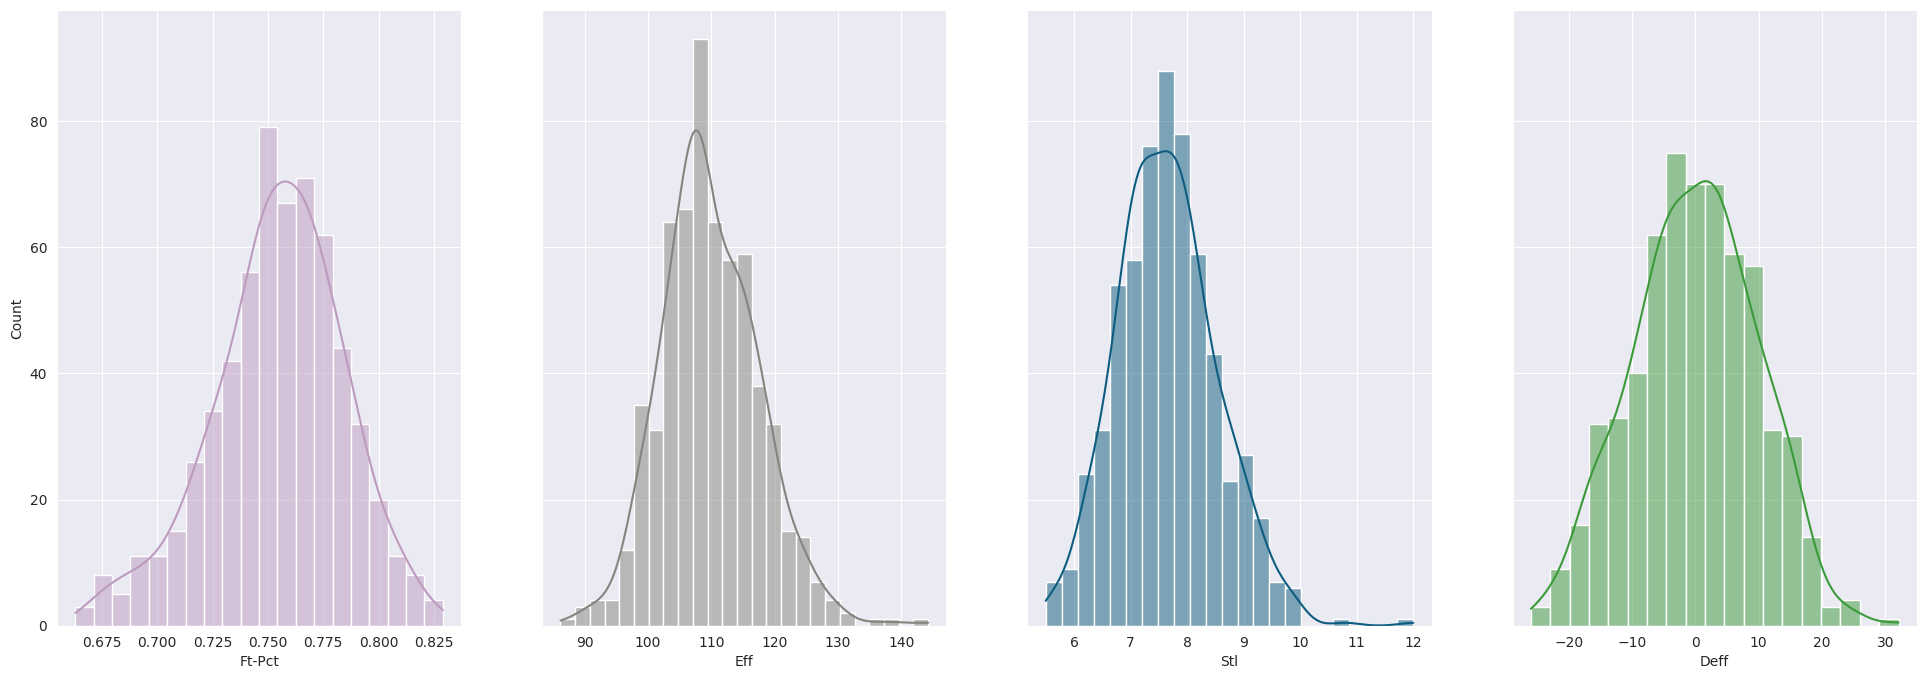

In [275]:
exclude = set(["Year", "Champion", "Team"])
fig,axes = plt.subplots(1, len(feat) , figsize = (24,8) , sharey = True)
i = 0
for f in feat:
    if f not in exclude:
        sns.histplot(df, ax = axes[i], x = f, kde = True, color=np.random.rand(3,))
        i += 1


<h3>Normal Distribution:</h3>

<br>

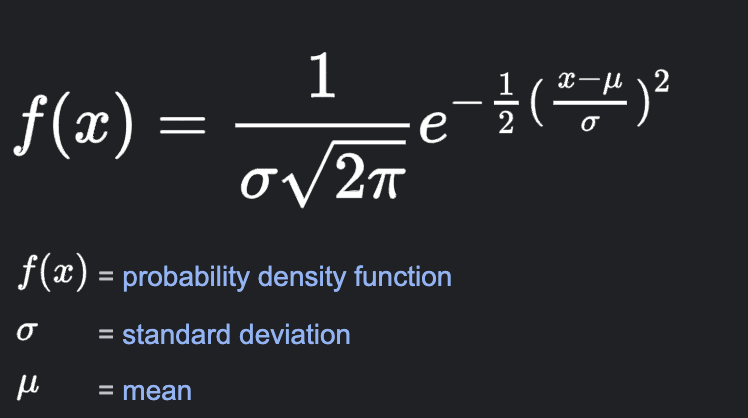



<h2> Instead of using dictonaries to store probabilities, we use PDFs: </h2>

$P(X = x) = f(u_X, \sigma_X, x)$

In [276]:

def pdf(df,  feature, x):
    # represents nodes in PGM
    mean, std = df[feature].mean(), df[feature].std()

    p =  (1 / (np.sqrt(2 * np.pi) * std)) *  np.exp(-((x-mean)**2 / (2 * std**2 )))
    # if p >= 1:
    #     print(mean,std,x )
    return p



pdf(df, "Deff", 0), pdf(df,"Deff", 20 )

(0.04055206453442979, 0.005037974076519528)

We want to find

P(Champion | $X_1 = x_1 , X_2 = x_2, . . . X_k = x_k$) for all k variables(excluding Champion).


P(Champion | $X_1 = x_1 , X_2 = x_2, . . . X_k = x_k$) = $\frac{P(X_1 = x_1 , X_2 = x_2, . . . X_k = x_k | Champion) * P(Champion) } {P(X_1 = x_1 , X_2 = x_2, . . . X_k = x_k)}$

We know that P(Champion) = 1/30

How do we calculate P($X_1 = x_1 , X_2 = x_2, . . . X_k = x_k$) ?



We assume $X_1, X_2 . . . X_k $ is independent ( Naive Bayes Assumption ).

<ipython-input-277-267be9c5e4d5>:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.iloc[:,:].corr(method = "pearson")


<Axes: >

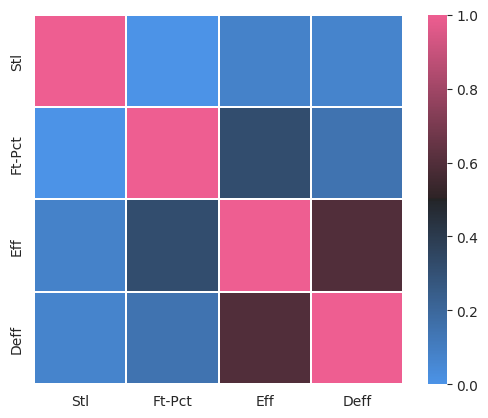

In [277]:
def create_heatmap(df):
    df = df.drop("No",axis = 1)
    prior_df = df.copy()
    df = df.drop("Champion",axis=1)
    corr = df.iloc[:,:].corr(method = "pearson")
    cmap = sns.diverging_palette(250,354,80,60, center = 'dark', as_cmap = True)
    hm = sns.heatmap(corr, vmax = 1, vmin=0,cmap = cmap, square= True, linewidths = 0.2)
    df = prior_df
    return hm


create_heatmap(df)

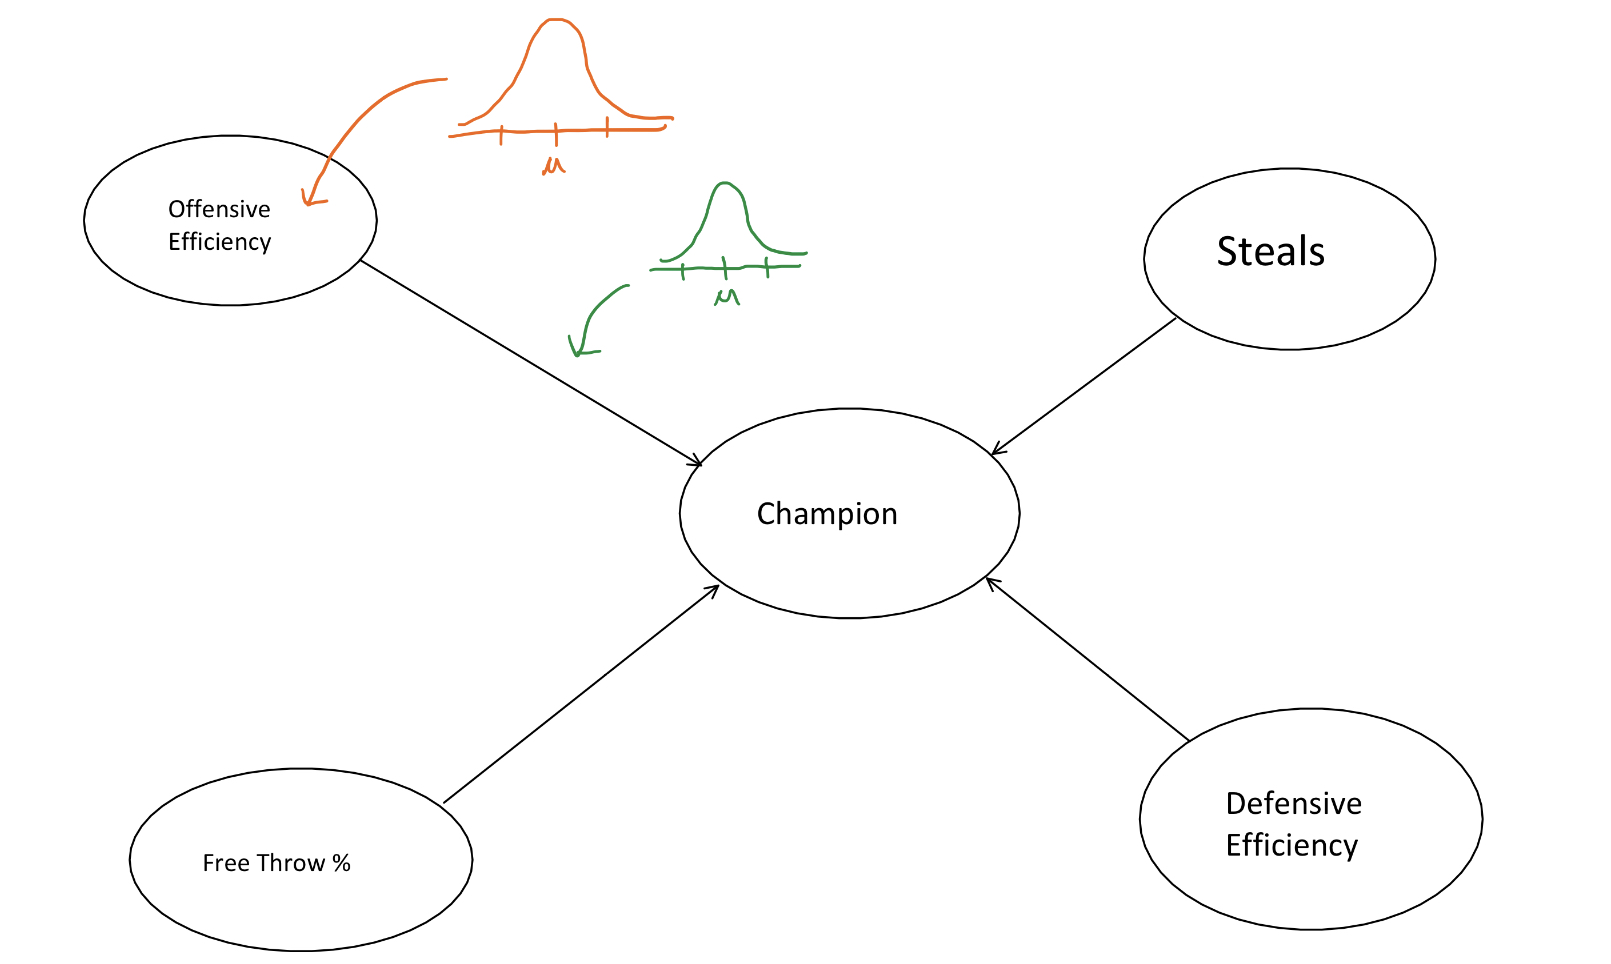

let $\vec{X} = X_1 = x_1 , X_2 = x_2, . . . X_k = x_k$



With this assumption:

$\underline{P(\vec{X}) = P(X_1 = x_1) * P(X_2 = x_2) * . . . P(X_k = x_k) }$

 - Use Nodes

However, $\vec{X}$ are not independent from the Champion variable, so

$ P(\vec{X}| Champion) = \frac{P(Champion, \vec{X} )}{ P(Champion)} $


P($Champion, \vec{X} ) = P(X_k | Champion, X_1, X_2 . . . X_{k-1}) * P(Champion, X_1, X_2 . . . X_{k-1})$

By conditional independence(Naive Bayes assumption) of $\vec{X}$:

$P(X_k | Champion, X_1, X_2 . . . X_{k-1}) = P(X_k | Champion)$

P($Champion, \vec{X} ) = P(X_k | Champion) * P(X_{k-1} | Champion) * . . . P(X_1 | Champion) * P(Champion) $

so

$ \underline{P(\vec{X} | Champion) = P(X_k | Champion) * P(X_{k-1} | Champion) * . . . P(X_1 | Champion)} $

 - Use Edge potentials

# Final Equations:




P(Champion | $\vec{X}$) = $\frac{P(\vec{X}| Champion) * P(Champion) } {P(\vec{X})}$

In [278]:

def conditional_pdf(df ,X, Y, x, y):
    #calculates P(X =x | Y = y)
    #represents edges in PGM

    df = df[df[Y]==y]

    p = pdf(df, X, x)
    return p

print(feat)

{'Ft-Pct', 'Eff', 'Stl', 'Deff'}


In [279]:
from numpy.ma.extras import average
from heapq import *
import scipy.stats as stats
from math import log2
# x1 = ["A" , "B" , "C" , "D", "E"]
# x2 = ["A" , "C" ,"B", "D", "E"]

# stats.spearmanr(x1, x2)

def get_finals_accuracy(pred_rank, true_rank, return_total = False):
    # gets accuracy in predicting whether a team will win the finals or not using the rankings
    # true_rank, pred_rank is teams ranked from hgheist to lowest odds
    assert len(pred_rank) == len(true_rank)

    tp = 1 * (pred_rank[0] == true_rank[0])
    tn = sum(map(lambda x : int(x != true_rank[0]), pred_rank[1:]))

    correct = tp+tn
    total = (len(pred_rank))
    acc = correct/total

    if not return_total:
        return acc
    else:
        return acc, correct, total

def get_corr(a, b):
    #calculates spearman correlation that is normalized to 0 to 1 range
    c = stats.spearmanr(a, b)[0]

    c= (c+1)/2

    return c



def heapsort(rankings):
    h = []
    for value ,team in rankings:
        heappush(h, (value, team))
    return [heappop(h) for i in range(len(h))]

def normalize(predictions):
    ret = []
    total_odds = sum([tup[0] for tup in predictions])
    for tup in predictions:
        odds, team = tup

        ret.append((odds/total_odds, team))

    return ret


def get_true_rankings(df, year):
    group = df[df["Year"] == year]
    trk = []
    for i ,row in group.iterrows():
        trk.append((row["No"], row["Team"]))

    return heapsort(trk)

class NaiveBayesModel:

    def __init__(self):#trainDf = None):
        self.df = None
        #self.fit(trainDf)

    def score_func(self, testDf, scorer = get_corr):

        grouped_df = testDf.groupby("Year")


        accs = []
        for name, group in grouped_df:
            x_test = group.drop("Champion", axis = 1)

            rk = self.get_ranking(x_test)

            true_rk = get_true_rankings(testDf, name)

            strip_rank = lambda tup : tup[1]

            rk = list(map(strip_rank, rk))

            true_rk = list(map(strip_rank, true_rk))
            assert(len(rk) == len(true_rk)) , f"{len(rk)}, {len(true_rk)}, {name}"
            accs.append(scorer(rk, true_rk))
            #for i, row in group.iterrows():

        acc = average(accs)


        return acc#, pred


    def score_spearman(self, testDf):
        return self.score_func(testDf, scorer = get_corr)

    def score_accuracy(self,testDf):
        return self.score_func(testDf, scorer = get_finals_accuracy)

    def score_precision(self,testDf):
        grouped_df = testDf.groupby("Year")

        tp = 0
        fp = 0
        for name, group in grouped_df:
            x_test = group.drop("Champion", axis = 1)

            rk = self.get_ranking(x_test)

            true_rk = get_true_rankings(testDf, name)

            strip_rank = lambda tup : tup[1]

            rk = list(map(strip_rank, rk))

            true_rk = list(map(strip_rank, true_rk))

            if rk[0] == true_rk[0]:
                tp += 1 # predicted #1 correctily
            else:
                fp += 1 # predicted #1 incorrectily
            #for i, row in group.iterrows():

        precision = tp/(tp+fp)


        return precision#, pred

    def score_recall(self,testDf):
        grouped_df = testDf.groupby("Year")

        tp = 0
        fn = 0
        for name, group in grouped_df:
            x_test = group.drop("Champion", axis = 1)

            rk = self.get_ranking(x_test)

            true_rk = get_true_rankings(testDf, name)

            strip_rank = lambda tup : tup[1]

            rk = list(map(strip_rank, rk))

            true_rk = list(map(strip_rank, true_rk))

            if rk[0] == true_rk[0]:
                tp += 1 # predicted #1 correctily
            else:
                fn += 1

            #for i, row in group.iterrows():

        recall = tp/(tp+fn)


        return recall#, pred



    def fit(self, trainDf):
        # model doesn't really need "tarining", simpply use conditional probailites of test data
        self.df = trainDf

        num_teams_per_year = self.df.groupby("Year").apply(lambda group : len(group["Team"].unique())).mean()
        self.P_CHAMP = 1/num_teams_per_year


        self.feat = set(self.df.columns)
        self.feat.remove("Year")
        self.feat.remove("Champion")
        self.feat.remove("Team")
        self.feat.remove("No")


        return self.score_spearman(trainDf), self.score_accuracy(trainDf), self.score_precision(trainDf)


    def get_ranking(self, group):
        '''
        group: datafram with nba data for a singel season, only needs X data
        BE SURE TO CALL self.fit() before runnning this method
        '''
         # sorted from 1 -> 30
        if self.df is None:
            raise Exception("Must fit model before making ranking predicitons.")

        pred = []
        for i, row in group.iterrows():

            p = self.get_posterior_championship_odds(row)
            pred.append((p, row["Team"] ))

        pred = normalize(pred)

        return list(reversed(heapsort(pred)))



    def get_posterior_championship_odds(self, row):
        p_x = 1

        for feature in self.feat:
            #processing nodes of PGM
            p_x *= pdf(self.df ,feature , row[feature])



        p_x_given_champion = 1
        for feature in self.feat:
            #process edges of PGM
            p_x_given_champion *= conditional_pdf(self.df, feature, "Champion", row[feature], 1)


        return (p_x_given_champion * self.P_CHAMP)/ p_x




    # def predict(self, row):
    #     p = 0
    #     p = self.get_posterior_championship_odds(row)
    #     team = row["Team"]
    #     year = row["Year"]
    #     print(f"{team} has a {p * 100}% chance of winning in {year}")


#2001-2002 , 2007-2008


Testing:
 - we will rank teams by their odds to win, and compare rankings with the actual rankings using Spearman's rank correlation.

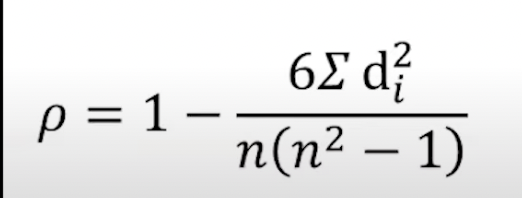


where $d_i$ is teh difference between the two ranks of a team i
and n is the number

In [280]:
from pprint import pprint
model = NaiveBayesModel()

def split_train_test_by_group(df, group_name = "Year", train_proportion = 0.9):
    # return train,test dfs with both X and Y data
    grouped = df.groupby("Year")

    total_groups = len(grouped)
    num_groups_to_select = int(total_groups * train_proportion)
    selected_group_keys = random.sample(list(grouped.groups.keys()), num_groups_to_select)

    nonselected_group_keys = [key for key in df["Year"].unique() if key not in selected_group_keys]

    selected_groups = [group for key, group in grouped if key in selected_group_keys]
    nonselected_groups = [group for key, group in grouped if key in nonselected_group_keys]


    #print([group.shape for group in selected_groups])
    train = pd.concat(selected_groups)
    test = pd.concat(nonselected_groups)

    return train,test


train_df, test_df = split_train_test_by_group(df, train_proportion = 0.9)


spearman_corr, acc, precision = model.fit(train_df)

print(f"Average Spearman Correlation (Train): {spearman_corr}")
print(f"Average Accuracy (Train): {acc}")
print(f"Average Precision (Train): {precision}")



print(f"Average Spearman Correlation (Test): {model.score_spearman(test_df)}")
print(f"Average Accuracy (Test): {model.score_accuracy(test_df)}")
print(f"Average Precision (Test): {model.score_precision(test_df)}")
print(f"Average Recall (Test): {model.score_recall(test_df)}")



Average Spearman Correlation (Train): 0.8365216201423098
Average Accuracy (Train): 0.9731800766283523
Average Precision (Train): 0.6111111111111112
Average Spearman Correlation (Test): 0.7442528735632182
Average Accuracy (Test): 0.9540229885057471
Average Precision (Test): 0.3333333333333333
Average Recall (Test): 0.3333333333333333


This means there is a positive correlation between model's rankings and actual rankings.

Let's Visualize Results:


In [281]:
def plot_rankings(rankings, year):
    fig,axes = plt.subplots(1, 1, figsize = (32,8) , sharey = True)
    ax = sns.barplot(x =[tup[1] for tup in rankings] , y= [tup[0] for tup in rankings] )

    ax.set(ylabel = "Chance to Win Championship")
    ax.set(title = f"Model's rankings for {year}")
    return



In [282]:
def compare_model_vs_actual(df, year):

    samp_df = df[df["Year"] == year]

    ranking = model.get_ranking(samp_df)
    #pprint(ranking)
    plot_rankings(ranking, year)

    print("ACTUAL RANKINGS:")
    pprint(get_true_rankings(df, year))

ACTUAL RANKINGS:
[(1, 'L.A.Lakers'),
 (2, 'Sacramento'),
 (3, 'San Antonio'),
 (4, 'Minnesota'),
 (5, 'New Jersey'),
 (6, 'Utah'),
 (7, 'Seattle'),
 (8, 'Portland'),
 (9, 'Dallas'),
 (10, 'Charlotte'),
 (11, 'Detroit'),
 (12, 'Indiana'),
 (13, 'Philadelphia'),
 (14, 'Miami'),
 (15, 'Toronto'),
 (16, 'Milwaukee'),
 (17, 'Boston'),
 (18, 'Phoenix'),
 (19, 'L.A.Clippers'),
 (20, 'Washington'),
 (21, 'Orlando'),
 (22, 'Cleveland'),
 (23, 'New York'),
 (24, 'Atlanta'),
 (25, 'Golden State'),
 (26, 'Houston'),
 (27, 'Denver'),
 (28, 'Memphis'),
 (29, 'Chicago')]


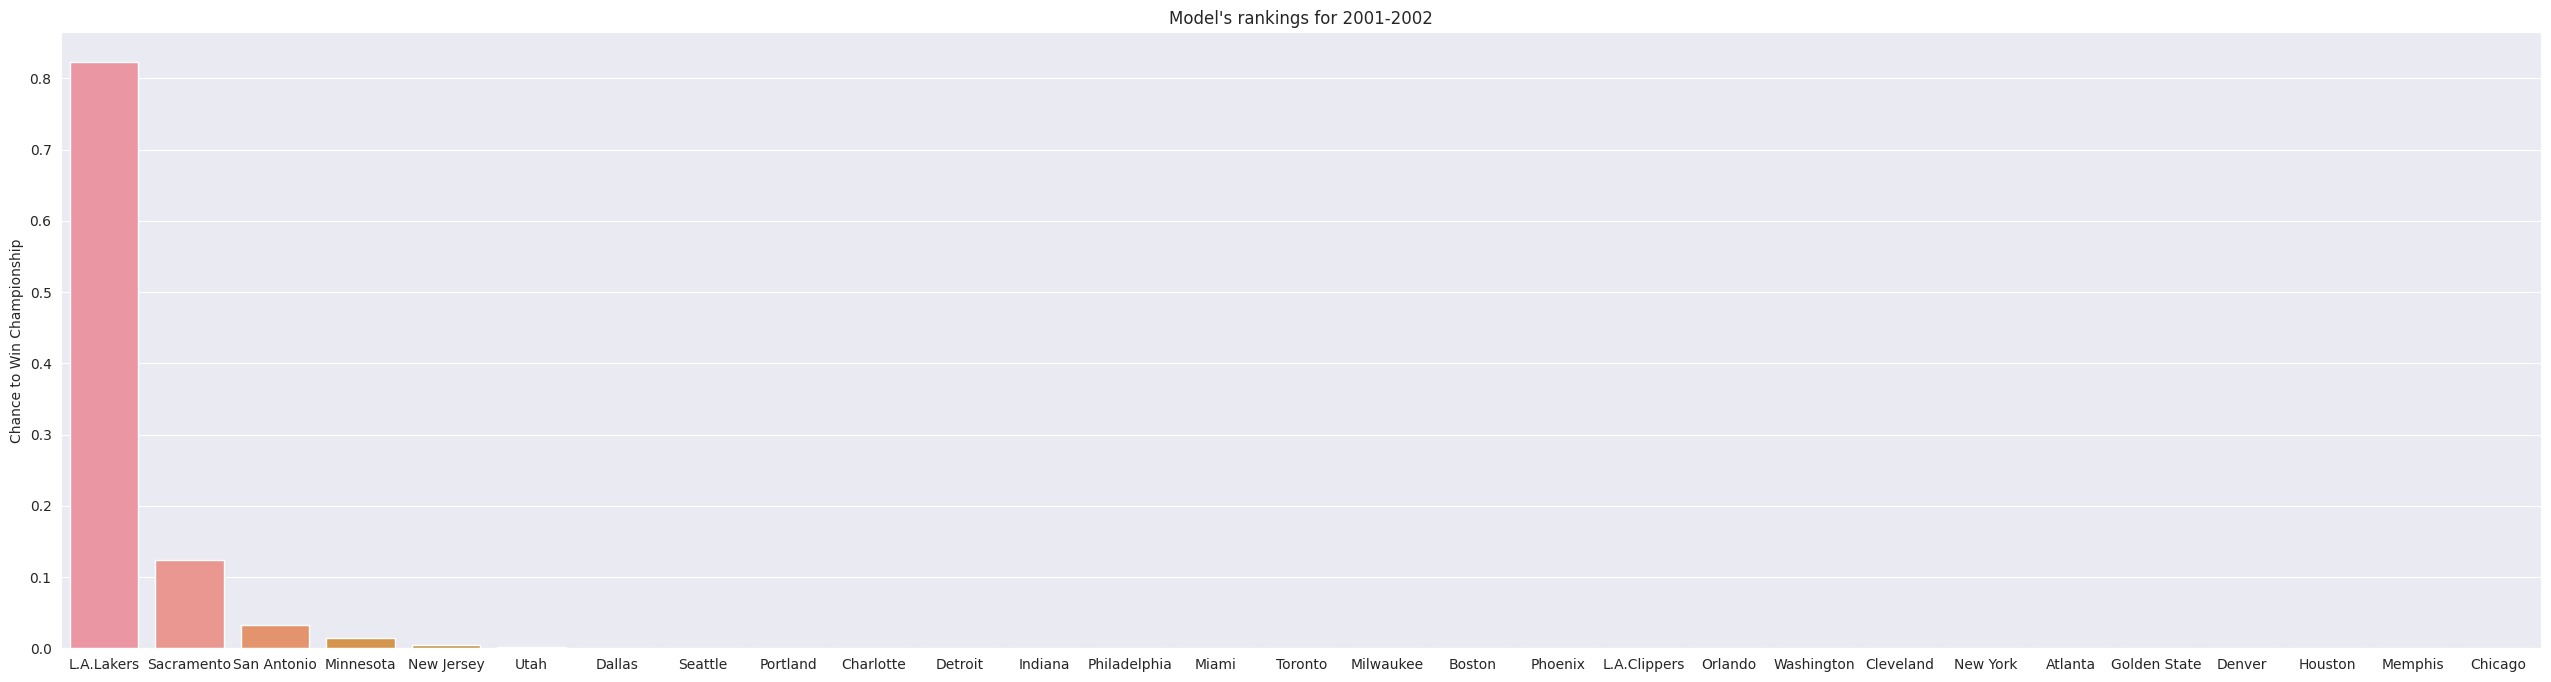

In [283]:
compare_model_vs_actual(df, "2001-2002")

Predictions from 2022-2023:


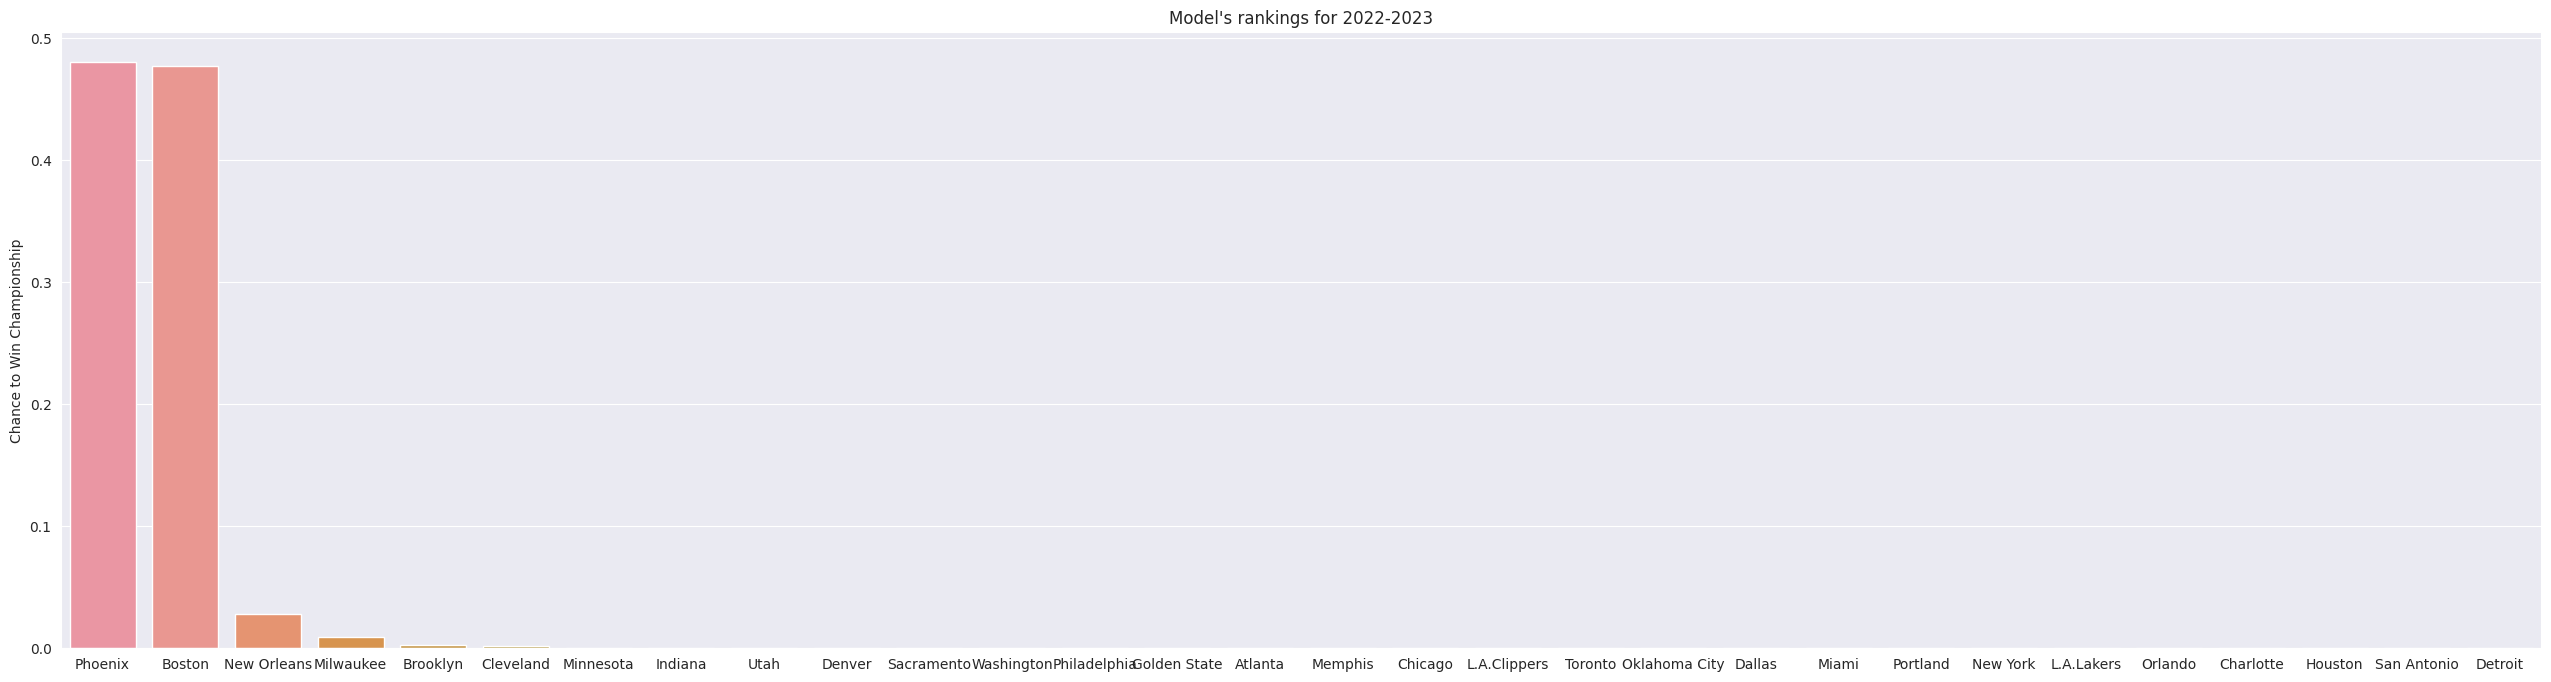

In [284]:
SEASON22_URL = 'https://drive.google.com/file/d/1WGM35XNpmrnDv-nv4oQdvr9HWnbCODdC/view?usp=sharing'
season_22_df = read_google_drive_csv(SEASON22_URL)
season_22_df = season_22_df.rename(mapper= {"Pct":"Fg-Pct", "Pct.1":"3-Pct"}, axis = 1)

season_22_df.dropna(axis=0, inplace=True)
season_22_rankings = model.get_ranking(season_22_df)
plot_rankings(season_22_rankings,"2022-2023")


What if we use different predictors?

<h1>Information Theory</h1>

Which Predictor provides the most mutual information about a Team's championship odds?

We want to find:

$MI(Champion, X_j)$  for $ j = 1 . . . k $

For discrete random variables:

$MI(i, j) =  \sum_{Champion} \sum_{X}^{} (P(a_i, b_j) * \log{\frac{P(a_i, b_j)}{P(a_i) * P(b_j)}})$

For continuous random variables:

$MI(i, j) =  \sum_{Champion} \int_{X}^{} (P(a_i, b_j) * \log{\frac{P(a_i, b_j)}{P(a_i) * P(b_j)}}$


$MI(Champion, X_j) =  \sum_{Champion} \int_{X}^{} (P(Champion, X_j) * \log{\frac{P(Champion, X_j)}{P(Champion) * P(X_j)}}$


$MI(Champion, X_j) =  \sum_{Champion} \int_{X}^{} (P(X_j | Champion) * P(Champion) * \log{\frac{(P(X_j | Champion) * P(Champion)}{P(Champion) * P(X_j)}}$


We only have two events in Champion , [0,1] :

$= MI(Champion = 0, X_j) + MI(Champion = 1, X_j)$



In [285]:
from math import log2
import scipy.integrate as integrate

# def get_surprise(p):

#     return log2(1/p)

P_CHAMP = 1/30

P_NOT_CHAMP = 1 - P_CHAMP

champ = {0 : P_NOT_CHAMP, 1 : P_CHAMP}

def get_mutual_info_for_champ(df, X, y):
    # calculates MI(Champion=y, X)

    func = lambda x : conditional_pdf(df, X, "Champion", x, y) * champ[y] * log2(conditional_pdf(df, X, "Champion", x, y) * champ[y] / (champ[y] * pdf(df, X, x)))


    mi = integrate.quad(func,df[X].min(), df[X].max())


    return mi[0]



def get_mutual_info_for_X(df, X):
    return get_mutual_info_for_champ(df, X, 0) + get_mutual_info_for_champ(df, X, 1)


res = []
tmp = []
for X in feat:
    res.append(get_mutual_info_for_X(df, X))
    tmp.append(X)


for i, entry in enumerate(res):
    res[i] = (res[i],tmp[i])


res = list(reversed(heapsort(res)))
pprint(res)


[(0.11805758583792644, 'Deff'),
 (0.04136749738853422, 'Eff'),
 (0.003989606423399884, 'Ft-Pct'),
 (0.0014225067560899684, 'Stl')]


Conclusions:

1.   Bayes theorem can be successfully applied to prediction problems with continuous variables
2.   Although PGMs can be very powerful, it is hard to get perfect classifiers for sports with just team statistics
3. Independence of non-target variables is important for Naive Bayes
4. Defensive and Offensive efficiency provide the most information about a teams championship odds
